In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [21]:
df = pd.read_csv("df_long.csv")

# 1) Eveolução no tempo

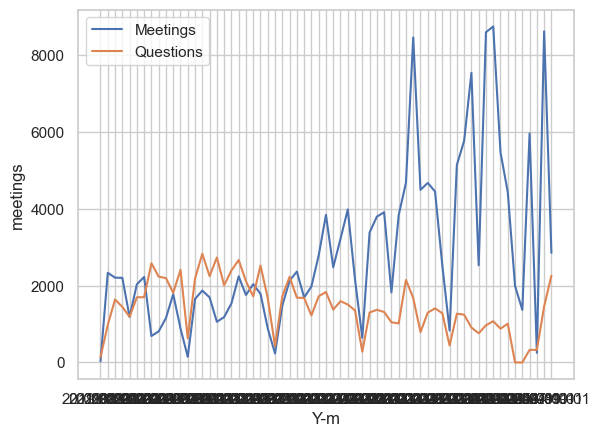

In [24]:
df_sum = df.groupby("Y-m").agg({"meetings": "sum", "questions": "sum"})

sns.lineplot(data=df_sum, x="Y-m", y="meetings", label="Meetings")
sns.lineplot(data=df_sum, x="Y-m", y="questions", label="Questions")
plt.show()

In [30]:
# =============================================================================
# COMPREHENSIVE DESCRIPTIVE ANALYSIS FOR PANEL DATA
# =============================================================================

import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set better plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Dataset shape:", df.shape)
print("Time period:", df['Y-m'].min(), "to", df['Y-m'].max())
print("Unique MEPs:", df['member_id'].nunique())
print("Unique domains:", df['domain'].nunique())


Dataset shape: (767151, 93)
Time period: 2019-08-01 to 2024-10-01
Unique MEPs: 1353
Unique domains: 9


In [31]:
# =============================================================================
# 1. SUMMARY STATISTICS TABLES
# =============================================================================

def create_summary_table(df, variables=['questions', 'meetings'], by_group=None):
    """Create comprehensive summary statistics table"""
    
    def summary_stats(data):
        return pd.Series({
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std': data.std(),
            'Min': data.min(),
            'Max': data.max(),
            'Q25': data.quantile(0.25),
            'Q75': data.quantile(0.75),
            'Zeros': (data == 0).sum(),
            'Zero %': (data == 0).mean() * 100
        })
    
    if by_group is None:
        # Overall summary
        summary = pd.DataFrame()
        for var in variables:
            summary[var] = summary_stats(df[var])
        return summary.round(3)
    else:
        # Group-wise summary
        summaries = {}
        for group in df[by_group].unique():
            group_data = df[df[by_group] == group]
            group_summary = pd.DataFrame()
            for var in variables:
                group_summary[var] = summary_stats(group_data[var])
            summaries[group] = group_summary
        return summaries

# Overall Summary Statistics
print("=== OVERALL SUMMARY STATISTICS ===")
overall_summary = create_summary_table(df)
print(overall_summary)


=== OVERALL SUMMARY STATISTICS ===
         questions    meetings
Count   767151.000  767151.000
Mean         0.120       0.236
Median       0.000       0.000
Std          0.506       1.382
Min          0.000       0.000
Max         16.000     153.000
Q25          0.000       0.000
Q75          0.000       0.000
Zeros   707604.000  709279.000
Zero %      92.238      92.456


In [32]:
# Summary by Domain
print("\n=== SUMMARY BY DOMAIN ===")
domain_summaries = create_summary_table(df, by_group='domain')
for domain, summary in domain_summaries.items():
    print(f"\n--- {str(domain).upper()} ---")
    print(summary)



=== SUMMARY BY DOMAIN ===

--- AGRICULTURE ---
           questions      meetings
Count   85239.000000  85239.000000
Mean        0.054036      0.144769
Median      0.000000      0.000000
Std         0.321111      0.929490
Min         0.000000      0.000000
Max        16.000000     63.000000
Q25         0.000000      0.000000
Q75         0.000000      0.000000
Zeros   81826.000000  80411.000000
Zero %     95.995964     94.335926

--- ECONOMICS_AND_TRADE ---
           questions      meetings
Count   85239.000000  85239.000000
Mean        0.128392      0.311594
Median      0.000000      0.000000
Std         0.512461      1.694949
Min         0.000000      0.000000
Max        13.000000    153.000000
Q25         0.000000      0.000000
Q75         0.000000      0.000000
Zeros   77977.000000  77739.000000
Zero %     91.480426     91.201211

--- EDUCATION ---
           questions      meetings
Count   85239.000000  85239.000000
Mean        0.027499      0.169594
Median      0.000000      0.0

In [33]:
# Treatment vs Control Comparison
print("\n=== TREATMENT VS CONTROL COMPARISON ===")
df['treated'] = (df['meetings'] > 0).astype(int)
treatment_comparison = df.groupby('treated')[['questions', 'meetings']].agg([
    'count', 'mean', 'median', 'std'
]).round(3)
print(treatment_comparison)

# Treatment intensity distribution
print("\n=== TREATMENT INTENSITY DISTRIBUTION ===")
treatment_dist = df[df['meetings'] > 0]['meetings'].describe()
print(treatment_dist)



=== TREATMENT VS CONTROL COMPARISON ===
        questions                      meetings                     
            count   mean median    std    count   mean median    std
treated                                                             
0          709279  0.107    0.0  0.486   709279  0.000    0.0  0.000
1           57872  0.275    0.0  0.685    57872  3.122    2.0  4.039

=== TREATMENT INTENSITY DISTRIBUTION ===
count    57872.000000
mean         3.122045
std          4.038831
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        153.000000
Name: meetings, dtype: float64


In [34]:
# =============================================================================
# 2. PANEL STRUCTURE ANALYSIS
# =============================================================================

print("=== PANEL STRUCTURE ===")

# Panel dimensions
n_meps = df['member_id'].nunique()
n_domains = df['domain'].nunique() 
n_periods = df['Y-m'].nunique()
total_possible_obs = n_meps * n_domains * n_periods
actual_obs = len(df)

panel_structure = pd.DataFrame({
    'Dimension': ['MEPs', 'Domains', 'Time Periods', 'Possible Obs', 'Actual Obs', 'Completeness %'],
    'Value': [n_meps, n_domains, n_periods, total_possible_obs, actual_obs, 
              round(actual_obs/total_possible_obs*100, 2)]
})
print(panel_structure.to_string(index=False))

# Balance by MEP
print("\n=== PANEL BALANCE BY MEP ===")
mep_obs = df.groupby('member_id').size()
balance_stats = pd.Series({
    'Min obs per MEP': mep_obs.min(),
    'Max obs per MEP': mep_obs.max(), 
    'Mean obs per MEP': mep_obs.mean(),
    'Expected obs per MEP': n_domains * n_periods,
    'Perfectly balanced MEPs': (mep_obs == n_domains * n_periods).sum(),
    'Balance rate %': (mep_obs == n_domains * n_periods).mean() * 100
})
print(balance_stats.round(2))


=== PANEL STRUCTURE ===
     Dimension    Value
          MEPs   1353.0
       Domains      9.0
  Time Periods     63.0
  Possible Obs 767151.0
    Actual Obs 767151.0
Completeness %    100.0

=== PANEL BALANCE BY MEP ===
Min obs per MEP             567.0
Max obs per MEP             567.0
Mean obs per MEP            567.0
Expected obs per MEP        567.0
Perfectly balanced MEPs    1353.0
Balance rate %              100.0
dtype: float64


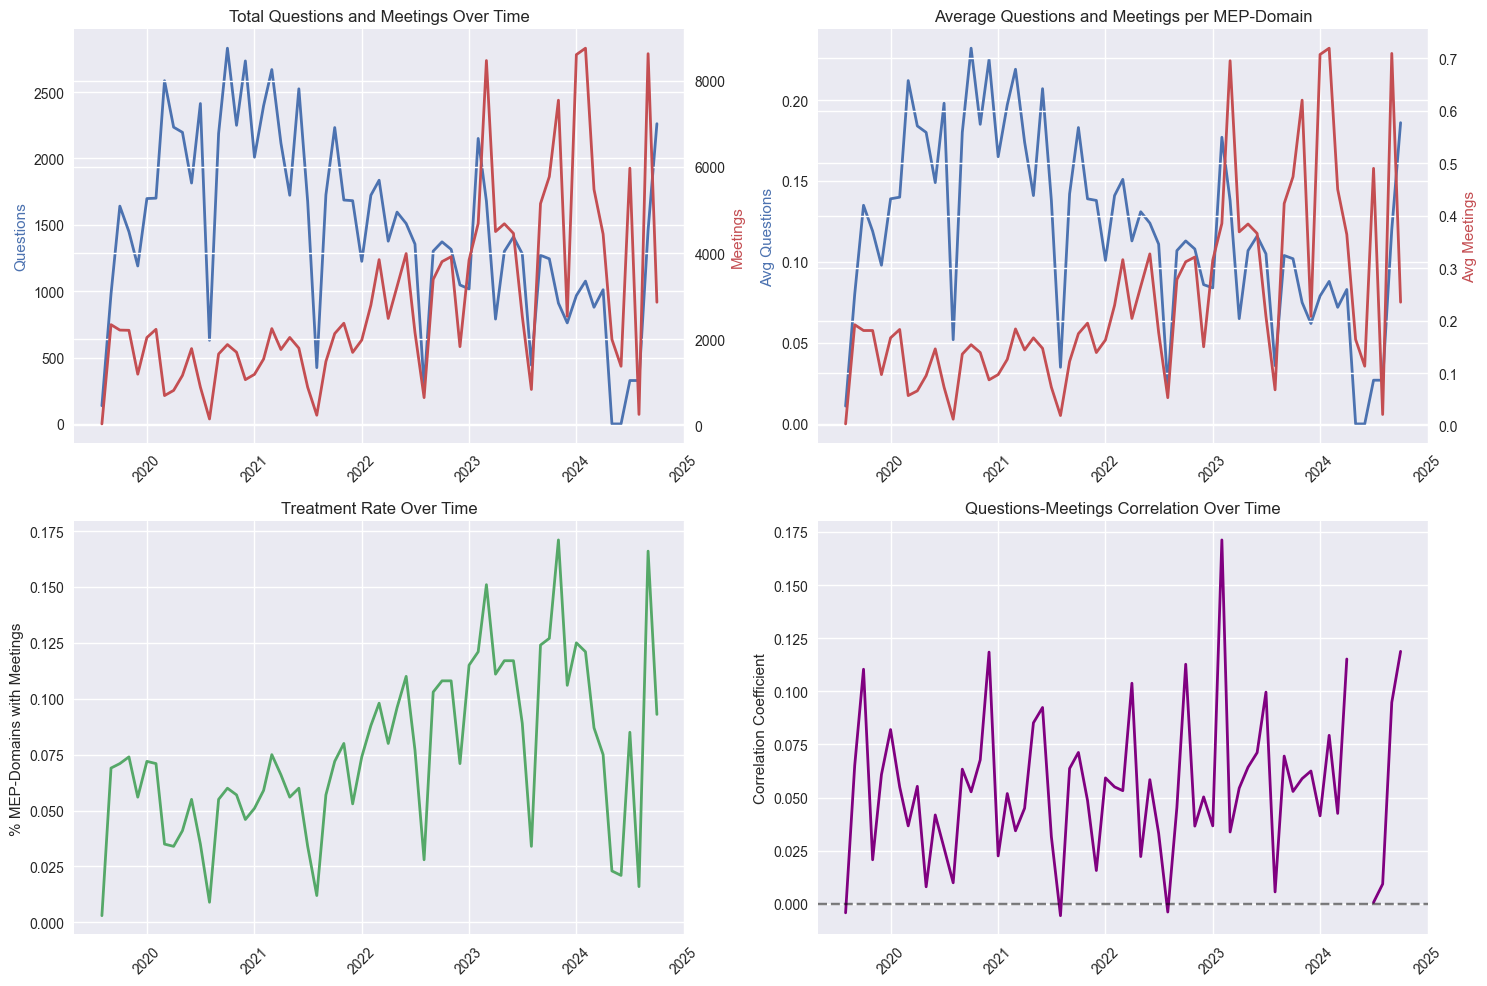

In [35]:
# =============================================================================
# 3. TIME SERIES VISUALIZATIONS
# =============================================================================

# Create time series aggregations
df_time = df.groupby('Y-m').agg({
    'questions': ['sum', 'mean'],
    'meetings': ['sum', 'mean'],
    'treated': 'mean'
}).round(3)

# Flatten column names
df_time.columns = ['_'.join(col).strip() for col in df_time.columns.values]
df_time = df_time.reset_index()

# Convert Y-m to datetime for better plotting
df_time['date'] = pd.to_datetime(df_time['Y-m'])

# Plot 1: Aggregate trends over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Total Questions and Meetings
ax1.plot(df_time['date'], df_time['questions_sum'], 'b-', linewidth=2, label='Total Questions')
ax1_twin = ax1.twinx()
ax1_twin.plot(df_time['date'], df_time['meetings_sum'], 'r-', linewidth=2, label='Total Meetings')
ax1.set_title('Total Questions and Meetings Over Time')
ax1.set_ylabel('Questions', color='b')
ax1_twin.set_ylabel('Meetings', color='r')
ax1.tick_params(axis='x', rotation=45)

# Average Questions and Meetings per MEP-Domain
ax2.plot(df_time['date'], df_time['questions_mean'], 'b-', linewidth=2, label='Avg Questions')
ax2_twin = ax2.twinx()
ax2_twin.plot(df_time['date'], df_time['meetings_mean'], 'r-', linewidth=2, label='Avg Meetings')
ax2.set_title('Average Questions and Meetings per MEP-Domain')
ax2.set_ylabel('Avg Questions', color='b')
ax2_twin.set_ylabel('Avg Meetings', color='r')
ax2.tick_params(axis='x', rotation=45)

# Treatment Rate Over Time
ax3.plot(df_time['date'], df_time['treated_mean'], 'g-', linewidth=2)
ax3.set_title('Treatment Rate Over Time')
ax3.set_ylabel('% MEP-Domains with Meetings')
ax3.tick_params(axis='x', rotation=45)

# Questions-Meetings Correlation Over Time
correlations = []
for period in df_time['Y-m']:
    period_data = df[df['Y-m'] == period]
    if len(period_data) > 1:
        corr = period_data['questions'].corr(period_data['meetings'])
        correlations.append(corr)
    else:
        correlations.append(np.nan)

ax4.plot(df_time['date'], correlations, 'purple', linewidth=2)
ax4.set_title('Questions-Meetings Correlation Over Time')
ax4.set_ylabel('Correlation Coefficient')
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


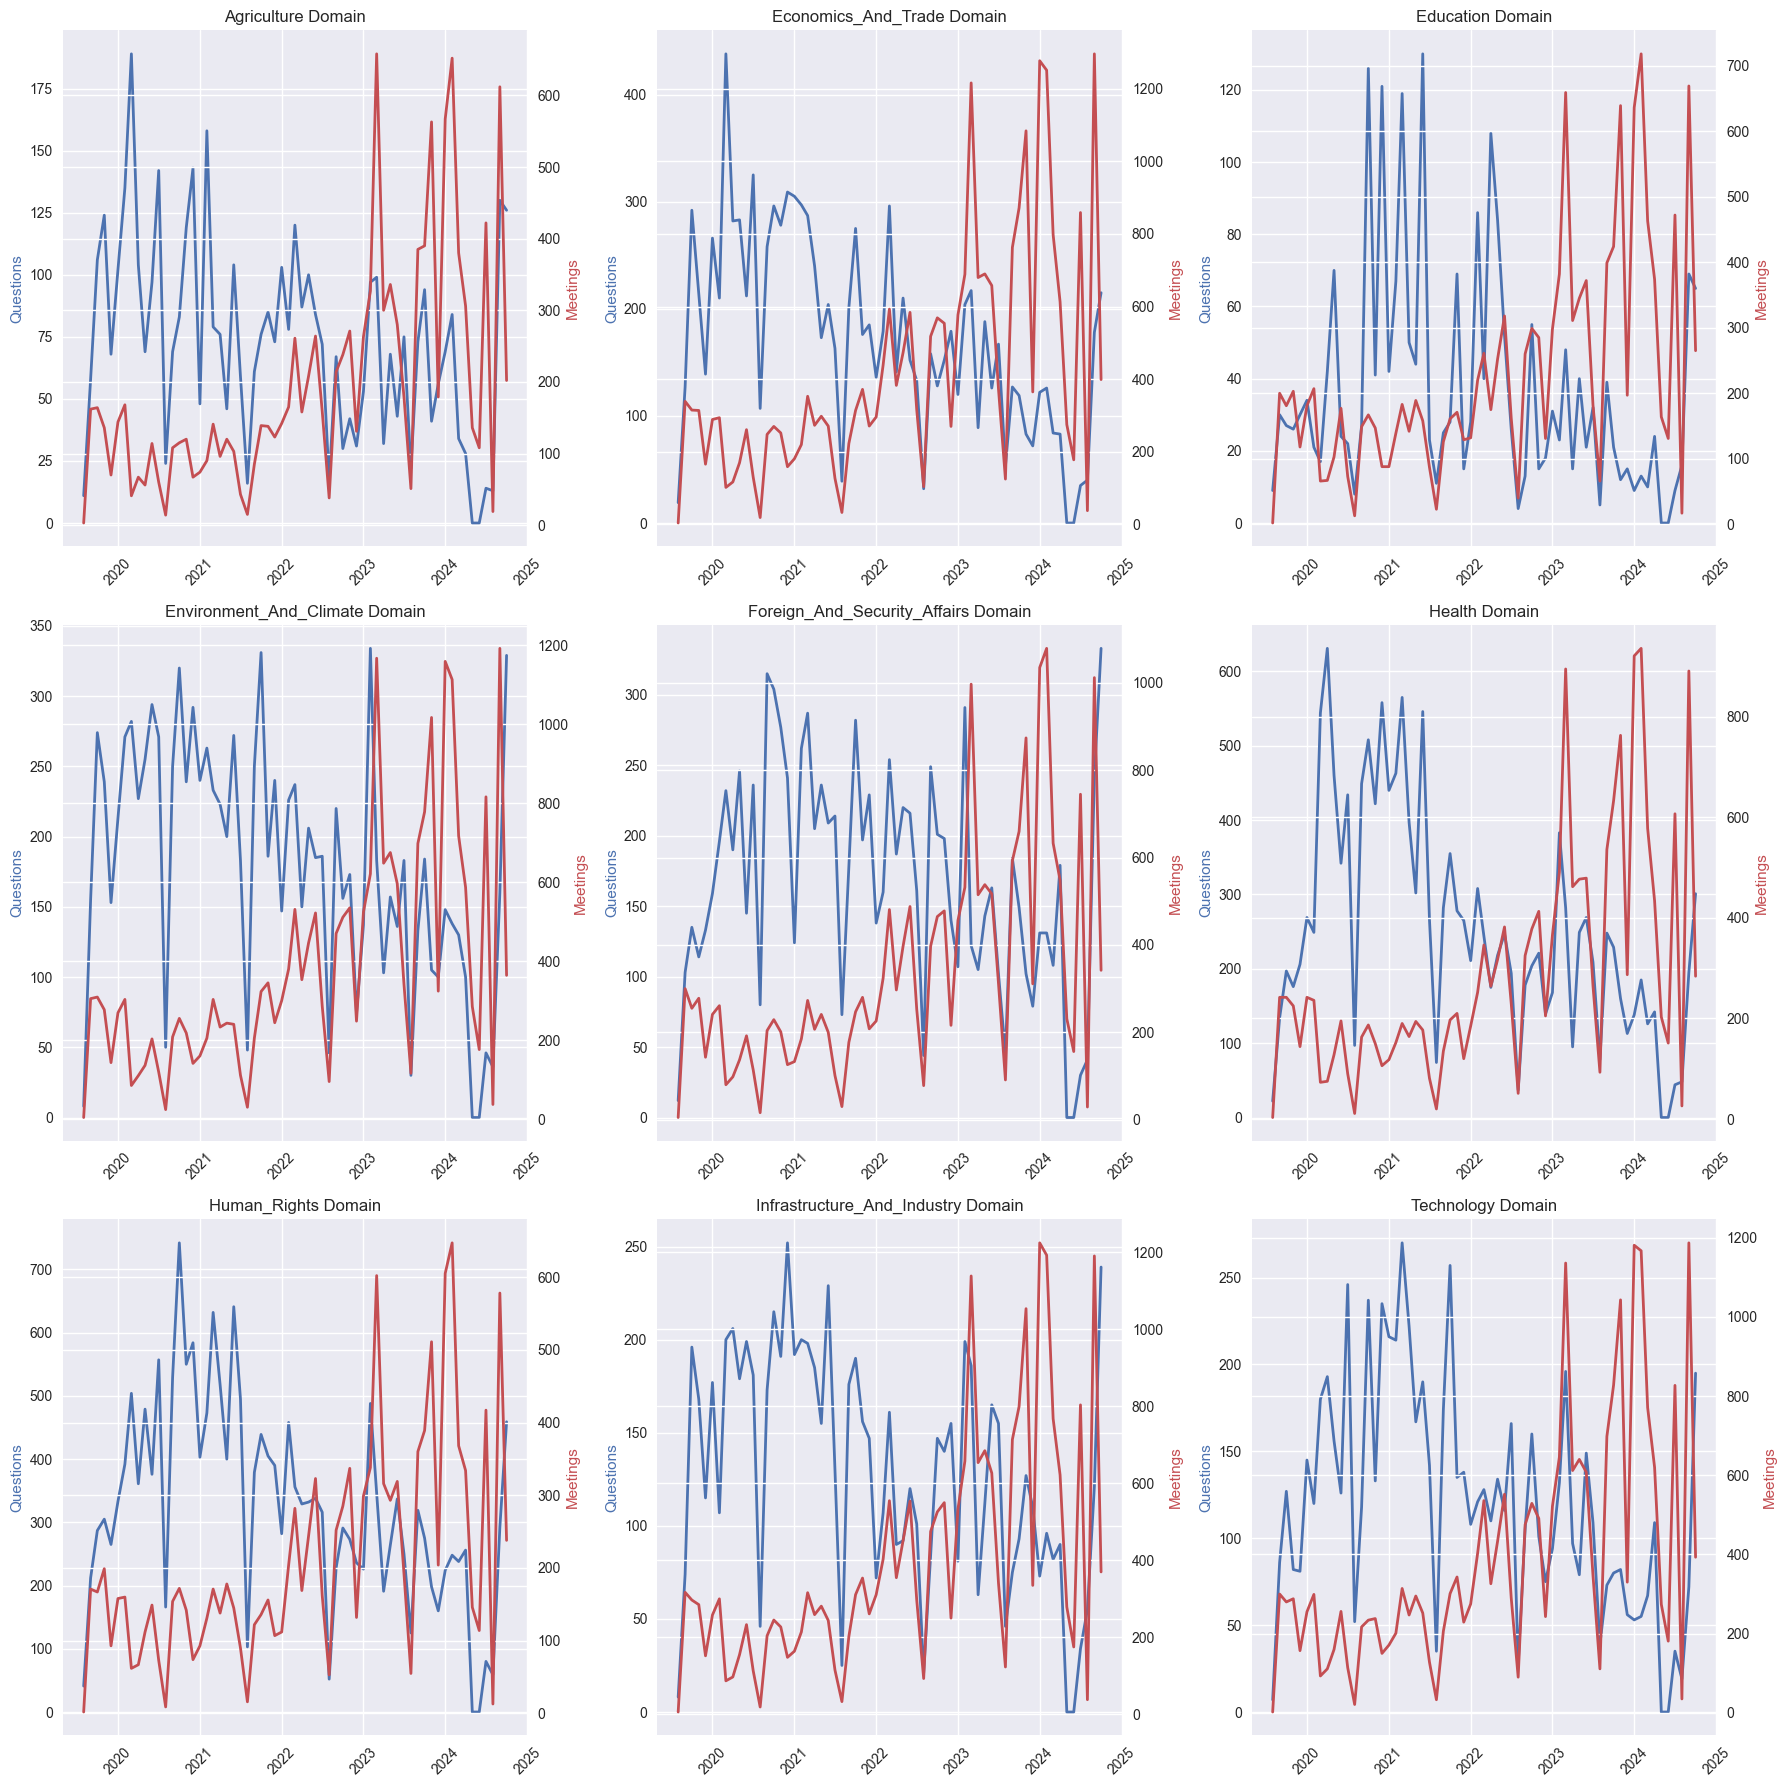

In [36]:
# =============================================================================
# 4. DOMAIN-SPECIFIC TIME SERIES
# =============================================================================

# Time series by domain
df_domain_time = df.groupby(['domain', 'Y-m']).agg({
    'questions': ['sum', 'mean'],
    'meetings': ['sum', 'mean']
}).round(3)

df_domain_time.columns = ['_'.join(col).strip() for col in df_domain_time.columns.values]
df_domain_time = df_domain_time.reset_index()
df_domain_time['date'] = pd.to_datetime(df_domain_time['Y-m'])

# Plot domain-specific trends
domains = df['domain'].unique()
n_domains = len(domains)
cols = 3
rows = (n_domains + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

for i, domain in enumerate(domains):
    domain_data = df_domain_time[df_domain_time['domain'] == domain]
    
    ax = axes[i]
    ax.plot(domain_data['date'], domain_data['questions_sum'], 'b-', linewidth=2, label='Questions')
    ax_twin = ax.twinx()
    ax_twin.plot(domain_data['date'], domain_data['meetings_sum'], 'r-', linewidth=2, label='Meetings')
    
    ax.set_title(f'{str(domain).title()} Domain')
    ax.set_ylabel('Questions', color='b')
    ax_twin.set_ylabel('Meetings', color='r')
    ax.tick_params(axis='x', rotation=45)

# Hide extra subplots
for i in range(n_domains, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


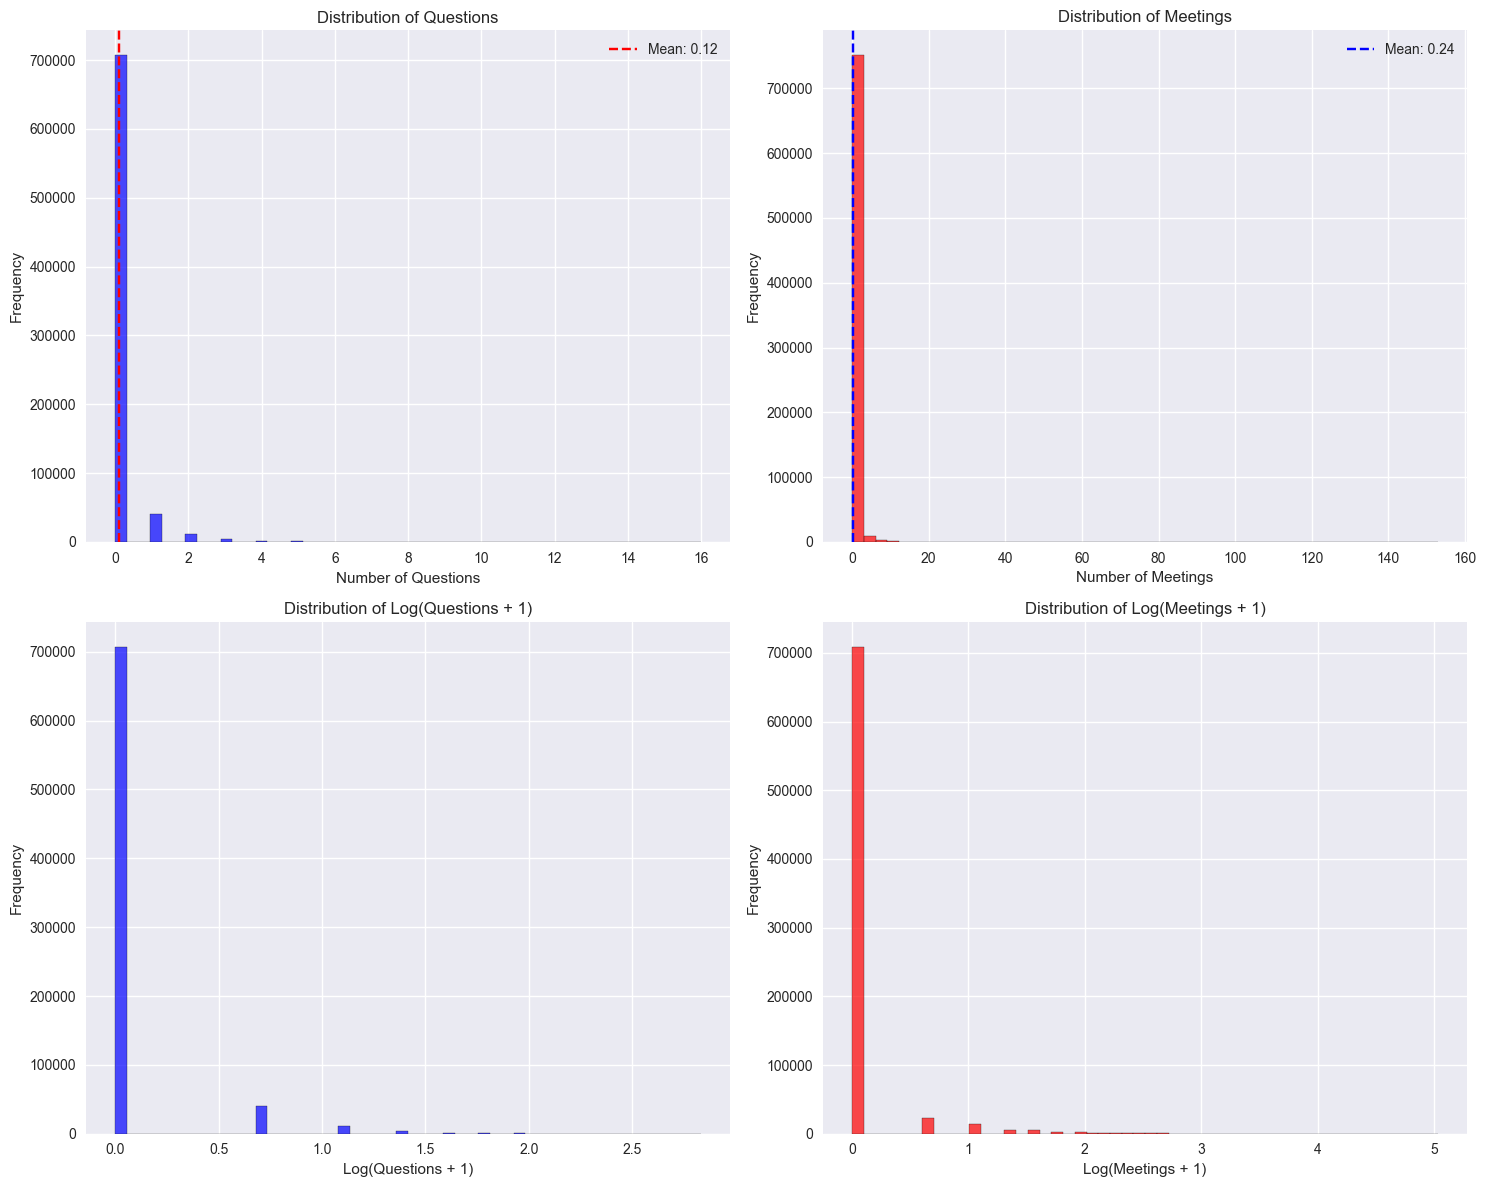

In [37]:
# =============================================================================
# 5. DISTRIBUTION ANALYSIS
# =============================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Questions distribution
ax1.hist(df['questions'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Distribution of Questions')
ax1.set_xlabel('Number of Questions')
ax1.set_ylabel('Frequency')
ax1.axvline(df['questions'].mean(), color='red', linestyle='--', label=f'Mean: {df["questions"].mean():.2f}')
ax1.legend()

# Meetings distribution
ax2.hist(df['meetings'], bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.set_title('Distribution of Meetings')
ax2.set_xlabel('Number of Meetings')
ax2.set_ylabel('Frequency')
ax2.axvline(df['meetings'].mean(), color='blue', linestyle='--', label=f'Mean: {df["meetings"].mean():.2f}')
ax2.legend()

# Log distributions (adding 1 to handle zeros)
questions_log = np.log1p(df['questions'])
meetings_log = np.log1p(df['meetings'])

ax3.hist(questions_log, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax3.set_title('Distribution of Log(Questions + 1)')
ax3.set_xlabel('Log(Questions + 1)')
ax3.set_ylabel('Frequency')

ax4.hist(meetings_log, bins=50, alpha=0.7, color='red', edgecolor='black')
ax4.set_title('Distribution of Log(Meetings + 1)')
ax4.set_xlabel('Log(Meetings + 1)')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


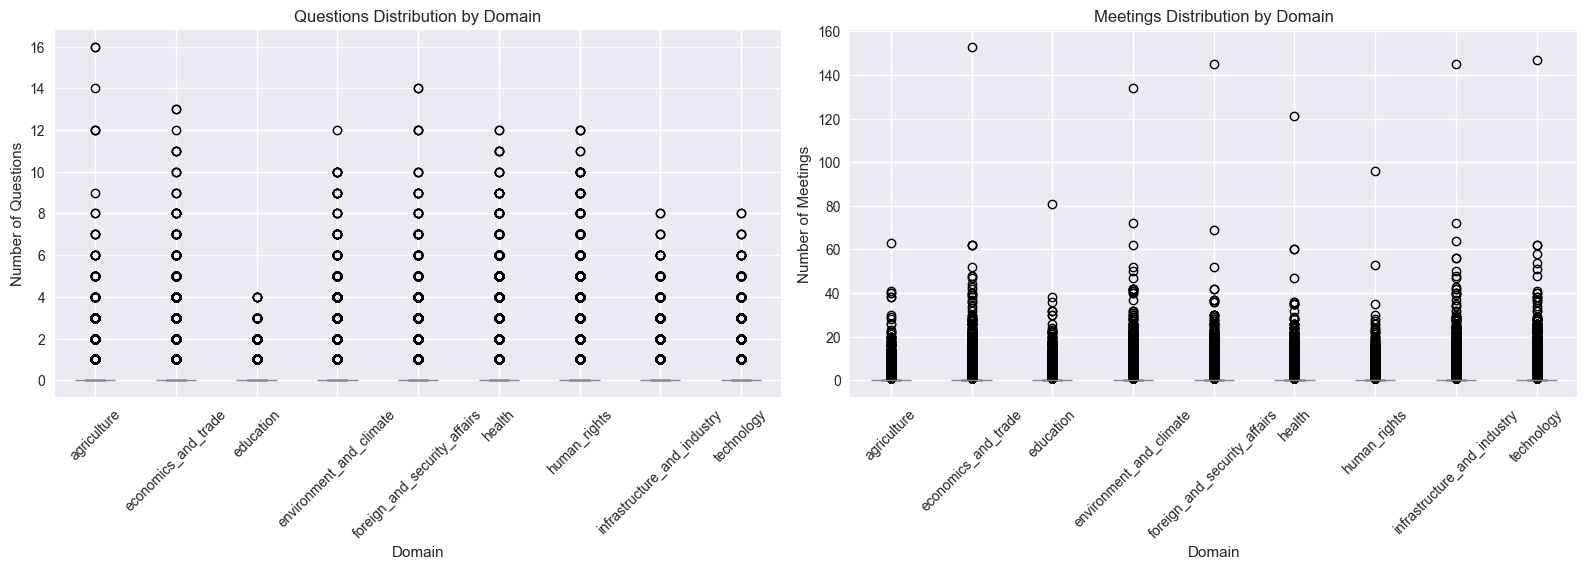

In [38]:
# =============================================================================
# 6. BOX PLOTS BY DOMAIN
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Questions by domain
df.boxplot(column='questions', by='domain', ax=ax1)
ax1.set_title('Questions Distribution by Domain')
ax1.set_xlabel('Domain')
ax1.set_ylabel('Number of Questions')
ax1.tick_params(axis='x', rotation=45)

# Meetings by domain
df.boxplot(column='meetings', by='domain', ax=ax2)
ax2.set_title('Meetings Distribution by Domain')
ax2.set_xlabel('Domain')
ax2.set_ylabel('Number of Meetings')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('')  # Remove the automatic title
plt.tight_layout()
plt.show()


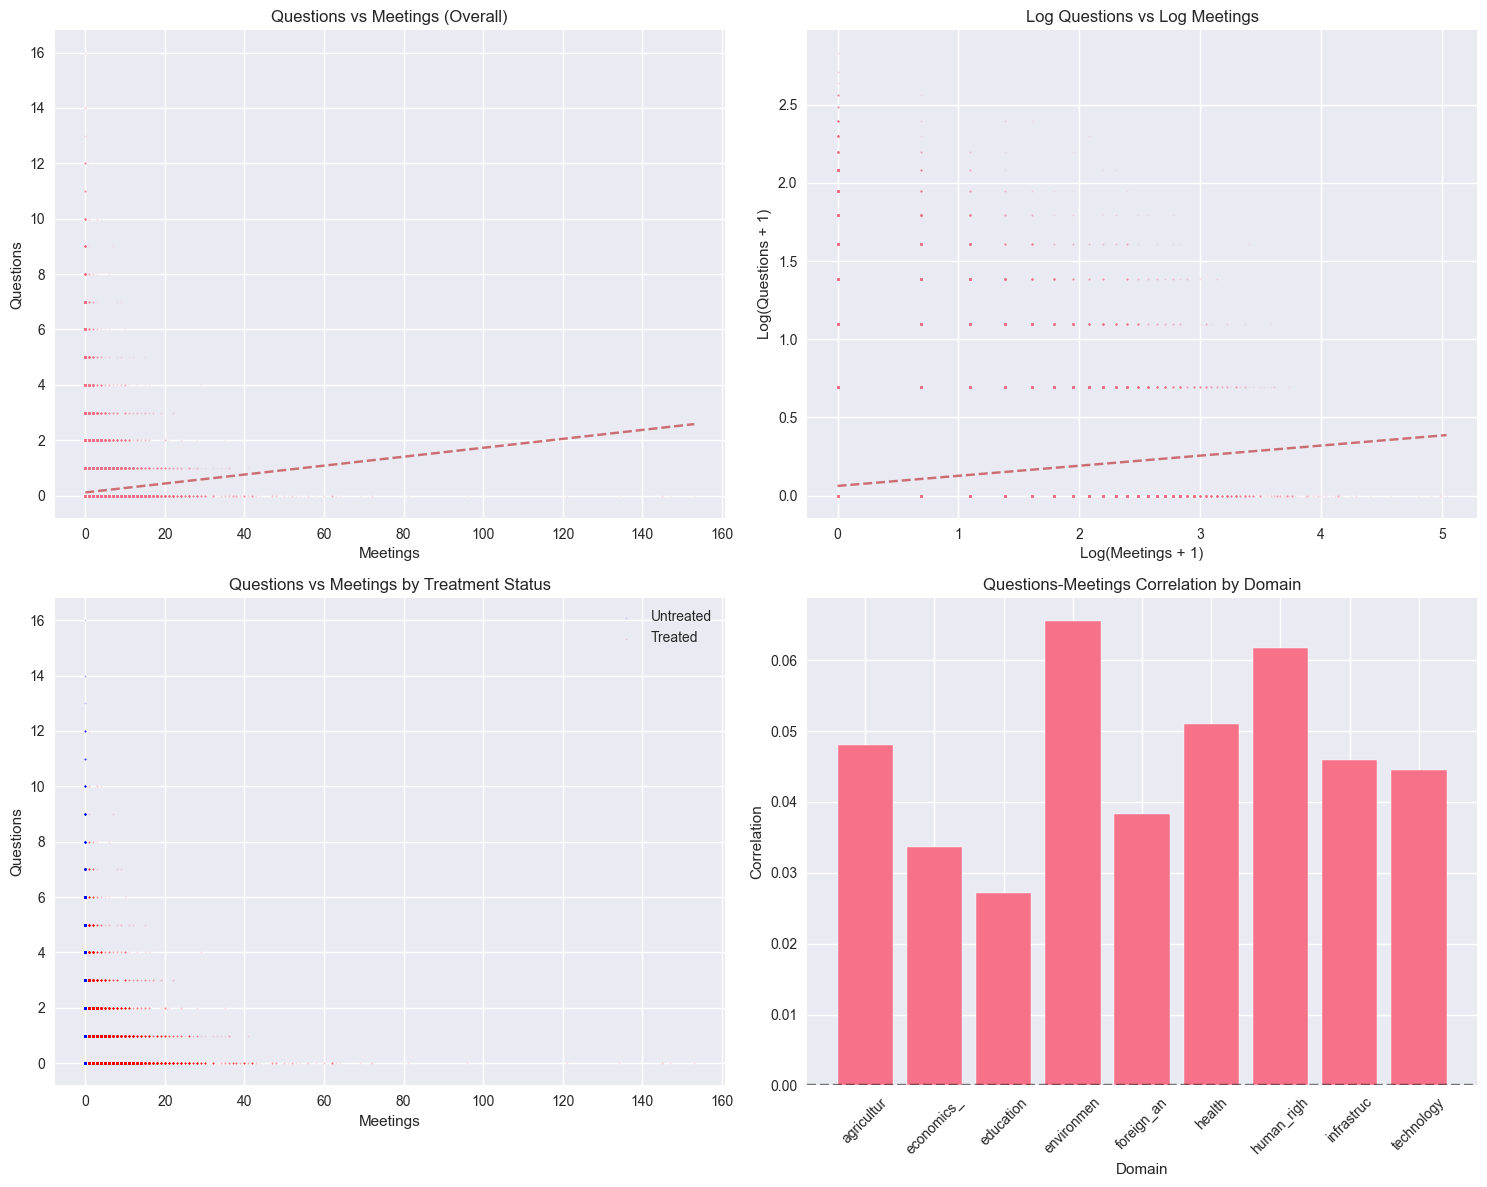

In [39]:
# =============================================================================
# 7. SCATTER PLOTS AND RELATIONSHIPS
# =============================================================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Overall Questions vs Meetings
ax1.scatter(df['meetings'], df['questions'], alpha=0.1, s=1)
ax1.set_xlabel('Meetings')
ax1.set_ylabel('Questions')
ax1.set_title('Questions vs Meetings (Overall)')

# Add trend line
z = np.polyfit(df['meetings'], df['questions'], 1)
p = np.poly1d(z)
ax1.plot(df['meetings'].sort_values(), p(df['meetings'].sort_values()), "r--", alpha=0.8)

# Log scale scatter
ax2.scatter(meetings_log, questions_log, alpha=0.1, s=1)
ax2.set_xlabel('Log(Meetings + 1)')
ax2.set_ylabel('Log(Questions + 1)')
ax2.set_title('Log Questions vs Log Meetings')

# Add trend line for log scale
z_log = np.polyfit(meetings_log, questions_log, 1)
p_log = np.poly1d(z_log)
ax2.plot(np.sort(meetings_log), p_log(np.sort(meetings_log)), "r--", alpha=0.8)

# Treatment effect visualization
treated_data = df[df['treated'] == 1]
untreated_data = df[df['treated'] == 0]

ax3.scatter(untreated_data['meetings'], untreated_data['questions'], 
           alpha=0.1, s=1, label='Untreated', color='blue')
ax3.scatter(treated_data['meetings'], treated_data['questions'], 
           alpha=0.1, s=1, label='Treated', color='red')
ax3.set_xlabel('Meetings')
ax3.set_ylabel('Questions')
ax3.set_title('Questions vs Meetings by Treatment Status')
ax3.legend()

# Correlation by domain
correlations_by_domain = df.groupby('domain').apply(
    lambda x: x['questions'].corr(x['meetings'])
).reset_index()
correlations_by_domain.columns = ['domain', 'correlation']

ax4.bar(range(len(correlations_by_domain)), correlations_by_domain['correlation'])
ax4.set_xlabel('Domain')
ax4.set_ylabel('Correlation')
ax4.set_title('Questions-Meetings Correlation by Domain')
ax4.set_xticks(range(len(correlations_by_domain)))
ax4.set_xticklabels([str(d)[:10] for d in correlations_by_domain['domain']], rotation=45)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [40]:
# =============================================================================
# 8. PANEL-SPECIFIC ANALYSIS
# =============================================================================

# Within vs Between variation
print("=== WITHIN VS BETWEEN VARIATION ===")

# Calculate within and between variation
mep_means = df.groupby('member_id')[['questions', 'meetings']].mean()
df_with_means = df.merge(mep_means, on='member_id', suffixes=('', '_mep_mean'))

df_with_means['questions_within'] = df_with_means['questions'] - df_with_means['questions_mep_mean']
df_with_means['meetings_within'] = df_with_means['meetings'] - df_with_means['meetings_mep_mean']

variation_analysis = pd.DataFrame({
    'Variable': ['Questions', 'Meetings'],
    'Total Var': [df['questions'].var(), df['meetings'].var()],
    'Between Var': [mep_means['questions'].var(), mep_means['meetings'].var()],
    'Within Var': [df_with_means['questions_within'].var(), df_with_means['meetings_within'].var()]
})

# Calculate percentage of variation
variation_analysis['Between %'] = (variation_analysis['Between Var'] / variation_analysis['Total Var'] * 100).round(2)
variation_analysis['Within %'] = (variation_analysis['Within Var'] / variation_analysis['Total Var'] * 100).round(2)

print(variation_analysis.round(4))


=== WITHIN VS BETWEEN VARIATION ===
    Variable  Total Var  Between Var  Within Var  Between %  Within %
0  Questions     0.2558       0.0446      0.2113      17.43     82.58
1   Meetings     1.9104       0.3809      1.5298      19.94     80.08



=== TREATMENT TIMING ANALYSIS ===
Total MEP-Domain pairs               12177
Ever treated pairs                    5353
Treatment rate %                 43.959924
Earliest treatment              2019-08-01
Latest treatment                2024-10-01
Most common treatment period    2019-09-01
dtype: object


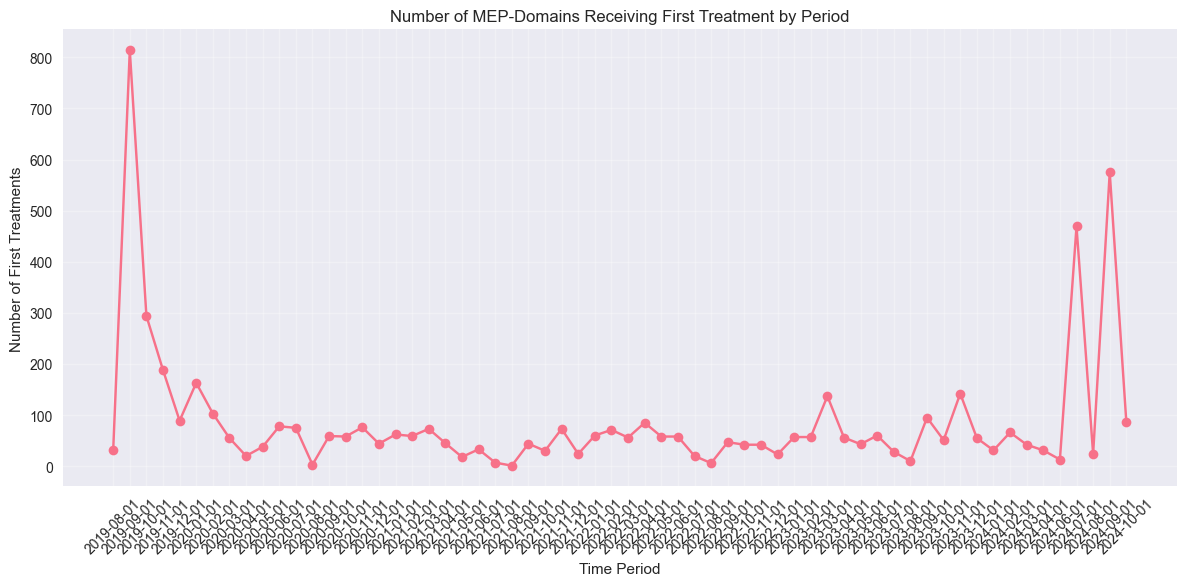

In [42]:
# Treatment timing analysis
print("\n=== TREATMENT TIMING ANALYSIS ===")

# First treatment timing for each MEP-domain
first_treatment = df[df['meetings'] > 0].groupby(['member_id', 'domain'])['Y-m'].min().reset_index()
first_treatment.columns = ['member_id', 'domain', 'first_treatment_period']

treatment_timing_stats = pd.Series({
    'Total MEP-Domain pairs': len(df.groupby(['member_id', 'domain'])),
    'Ever treated pairs': len(first_treatment),
    'Treatment rate %': len(first_treatment) / len(df.groupby(['member_id', 'domain'])) * 100,
    'Earliest treatment': first_treatment['first_treatment_period'].min(),
    'Latest treatment': first_treatment['first_treatment_period'].max(),
    'Most common treatment period': first_treatment['first_treatment_period'].mode().iloc[0]
})
print(treatment_timing_stats)

# Plot treatment timing
plt.figure(figsize=(12, 6))
treatment_counts = first_treatment['first_treatment_period'].value_counts().sort_index()
plt.plot(treatment_counts.index, treatment_counts.values, marker='o')
plt.title('Number of MEP-Domains Receiving First Treatment by Period')
plt.xlabel('Time Period')
plt.ylabel('Number of First Treatments')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


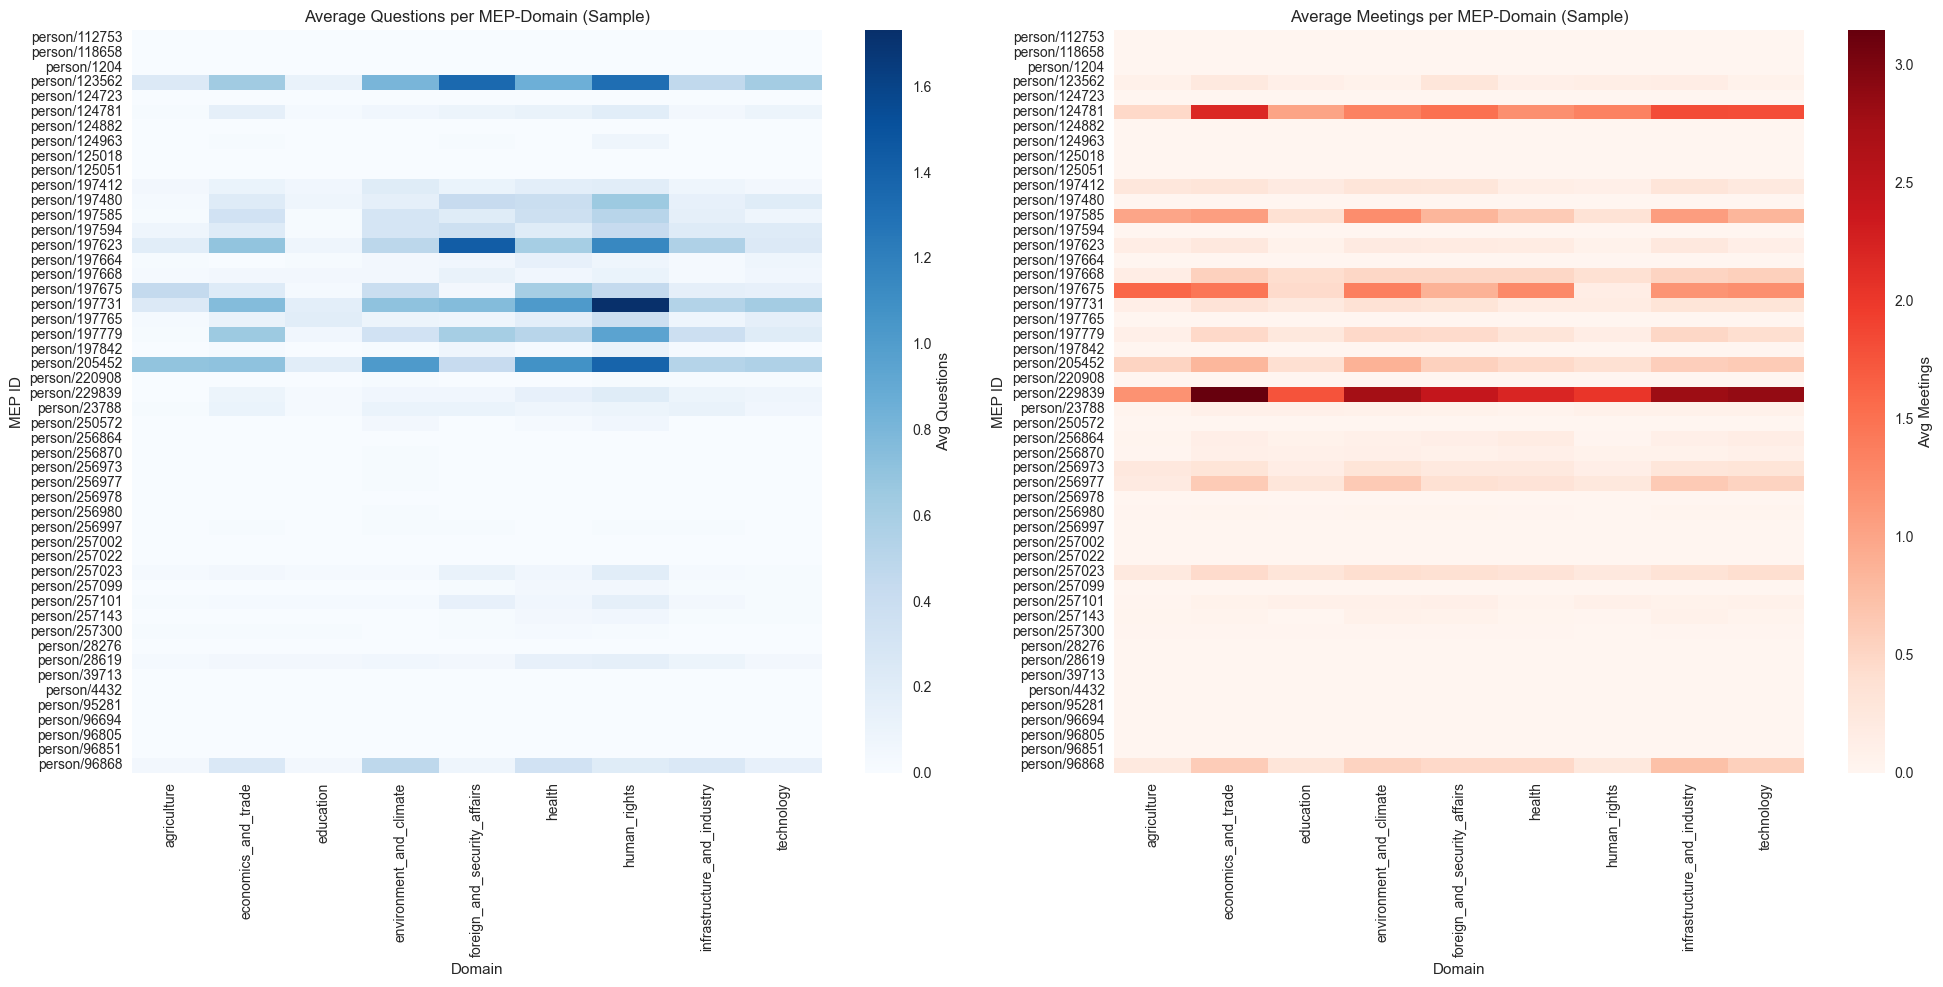

In [43]:
# =============================================================================
# 9. HEAT MAPS AND CROSS-TABULATIONS
# =============================================================================

# Create MEP-Domain activity heatmap (sample for visualization)
# Sample random MEPs for visualization purposes
sample_meps = df['member_id'].drop_duplicates().sample(min(50, df['member_id'].nunique()), random_state=42)
sample_data = df[df['member_id'].isin(sample_meps)]

# Create pivot tables for heatmaps
questions_pivot = sample_data.groupby(['member_id', 'domain'])['questions'].mean().unstack(fill_value=0)
meetings_pivot = sample_data.groupby(['member_id', 'domain'])['meetings'].mean().unstack(fill_value=0)

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Questions heatmap
sns.heatmap(questions_pivot, cmap='Blues', ax=ax1, cbar_kws={'label': 'Avg Questions'})
ax1.set_title('Average Questions per MEP-Domain (Sample)')
ax1.set_xlabel('Domain')
ax1.set_ylabel('MEP ID')

# Meetings heatmap
sns.heatmap(meetings_pivot, cmap='Reds', ax=ax2, cbar_kws={'label': 'Avg Meetings'})
ax2.set_title('Average Meetings per MEP-Domain (Sample)')
ax2.set_xlabel('Domain')
ax2.set_ylabel('MEP ID')

plt.tight_layout()
plt.show()


In [44]:
# =============================================================================
# 10. EXPORT SUMMARY TABLES FOR PUBLICATION
# =============================================================================

# Create publication-ready summary table
def create_publication_table():
    """Create a comprehensive summary table suitable for publication"""
    
    # Overall statistics
    overall_stats = pd.DataFrame({
        'Variables': ['Questions', 'Meetings'],
        'Observations': [len(df), len(df)],
        'Mean': [df['questions'].mean(), df['meetings'].mean()],
        'Std Dev': [df['questions'].std(), df['meetings'].std()],
        'Min': [df['questions'].min(), df['meetings'].min()],
        'Max': [df['questions'].max(), df['meetings'].max()],
        'Zero Values': [(df['questions'] == 0).sum(), (df['meetings'] == 0).sum()],
        'Zero %': [(df['questions'] == 0).mean() * 100, (df['meetings'] == 0).mean() * 100]
    }).round(3)
    
    return overall_stats

# Create and display publication table
pub_table = create_publication_table()
print("=== PUBLICATION-READY SUMMARY TABLE ===")
print(pub_table.to_string(index=False))

# Domain-level summary for publication
domain_pub_table = df.groupby('domain').agg({
    'questions': ['count', 'mean', 'std'],
    'meetings': ['count', 'mean', 'std'],
    'treated': 'mean'
}).round(3)

domain_pub_table.columns = ['_'.join(col).strip() for col in domain_pub_table.columns.values]
print("\n=== DOMAIN-LEVEL SUMMARY ===")
print(domain_pub_table)


=== PUBLICATION-READY SUMMARY TABLE ===
Variables  Observations  Mean  Std Dev  Min   Max  Zero Values  Zero %
Questions        767151 0.120    0.506  0.0  16.0       707604  92.238
 Meetings        767151 0.236    1.382  0.0 153.0       709279  92.456

=== DOMAIN-LEVEL SUMMARY ===
                              questions_count  questions_mean  questions_std  \
domain                                                                         
agriculture                             85239           0.054          0.321   
economics_and_trade                     85239           0.128          0.512   
education                               85239           0.027          0.188   
environment_and_climate                 85239           0.133          0.523   
foreign_and_security_affairs            85239           0.124          0.500   
health                                  85239           0.187          0.662   
human_rights                            85239           0.240          0.770 

# Summary of Recommended Descriptive Analysis

## Essential Tables for Your Panel Data:

### 1. **Summary Statistics Tables**
- **Overall**: Mean, median, std dev, min, max for questions and meetings
- **By Domain**: Same statistics broken down by policy domain
- **Treatment vs Control**: Compare treated (meetings > 0) vs untreated MEPs
- **Zero-inflation analysis**: Percentage of zeros in both variables

### 2. **Panel Structure Tables**
- **Dimensions**: Number of MEPs, domains, time periods
- **Balance**: Completeness of the panel
- **Treatment coverage**: How many MEP-domain pairs ever receive treatment

### 3. **Cross-tabulations**
- **MEP-Domain treatment intensity matrix**
- **Treatment timing distribution**
- **Extensive vs intensive margin analysis**

## Essential Visualizations:

### 1. **Time Series Plots**
- Aggregate trends for questions and meetings over time
- Domain-specific time series
- Treatment rate evolution
- Correlation stability over time

### 2. **Distribution Analysis**
- Histograms for both variables (levels and logs)
- Box plots by domain
- Treatment vs control distributions

### 3. **Relationship Visualizations**
- Scatter plots (questions vs meetings)
- By domain correlations
- Within vs between variation plots

### 4. **Panel-Specific Analysis**
- Heat maps showing MEP-domain activity patterns
- Treatment timing visualization
- First treatment period distribution

## Key Insights These Will Reveal:
- **Zero-inflation patterns** in your dependent variable
- **Domain heterogeneity** in both treatment and outcome
- **Temporal trends** that might affect your identification strategy
- **Treatment variation** crucial for causal inference
- **Panel balance** issues that might affect your estimates


In [46]:
# =============================================================================
# ENHANCED ANALYSIS BASED ON SUMMARY STATISTICS
# =============================================================================

print("=== ANALYSIS OF HIGH ZERO-INFLATION ===")
print("Your data shows:")
print("- Questions: 92.24% zeros (707,604 out of 767,151 observations)")
print("- Meetings: 92.46% zeros (709,279 out of 767,151 observations)")
print("This extreme zero-inflation has important implications for your analysis!\n")

# Detailed zero-inflation analysis
zero_analysis = pd.DataFrame({
    'Variable': ['Questions', 'Meetings'],
    'Total_Obs': [len(df), len(df)],
    'Zero_Count': [(df['questions'] == 0).sum(), (df['meetings'] == 0).sum()],
    'Zero_Percent': [(df['questions'] == 0).mean() * 100, (df['meetings'] == 0).mean() * 100],
    'Non_Zero_Count': [(df['questions'] > 0).sum(), (df['meetings'] > 0).sum()],
    'Non_Zero_Percent': [(df['questions'] > 0).mean() * 100, (df['meetings'] > 0).mean() * 100],
    'Mean_If_Positive': [df[df['questions'] > 0]['questions'].mean(), 
                        df[df['meetings'] > 0]['meetings'].mean()],
    'Max_Value': [df['questions'].max(), df['meetings'].max()]
}).round(3)

print(zero_analysis.to_string(index=False))


=== ANALYSIS OF HIGH ZERO-INFLATION ===
Your data shows:
- Questions: 92.24% zeros (707,604 out of 767,151 observations)
- Meetings: 92.46% zeros (709,279 out of 767,151 observations)
This extreme zero-inflation has important implications for your analysis!

 Variable  Total_Obs  Zero_Count  Zero_Percent  Non_Zero_Count  Non_Zero_Percent  Mean_If_Positive  Max_Value
Questions     767151      707604        92.238           59547             7.762             1.546       16.0
 Meetings     767151      709279        92.456           57872             7.544             3.122      153.0


In [47]:
# =============================================================================
# EXTENSIVE VS INTENSIVE MARGIN ANALYSIS
# =============================================================================

print("\n=== EXTENSIVE VS INTENSIVE MARGIN ===")

# Extensive margin: Does MEP ask questions/have meetings? (0/1)
# Intensive margin: How many questions/meetings conditional on >0?

extensive_intensive = pd.DataFrame({
    'Margin': ['Extensive (Any Activity)', 'Intensive (Mean if >0)'],
    'Questions': [
        (df['questions'] > 0).mean() * 100,  # % with any questions
        df[df['questions'] > 0]['questions'].mean()  # Mean questions if >0
    ],
    'Meetings': [
        (df['meetings'] > 0).mean() * 100,  # % with any meetings
        df[df['meetings'] > 0]['meetings'].mean()  # Mean meetings if >0
    ]
}).round(3)

print(extensive_intensive.to_string(index=False))

# Cross-tabulation of extensive margins
print("\n=== CROSS-TABULATION: QUESTIONS vs MEETINGS ACTIVITY ===")
df['has_questions'] = (df['questions'] > 0).astype(int)
df['has_meetings'] = (df['meetings'] > 0).astype(int)

crosstab = pd.crosstab(df['has_questions'], df['has_meetings'], 
                      margins=True, margins_name='Total')
crosstab_pct = pd.crosstab(df['has_questions'], df['has_meetings'], 
                          normalize='all', margins=True, margins_name='Total') * 100

print("COUNTS:")
print(crosstab)
print("\nPERCENTAGES:")
print(crosstab_pct.round(2))



=== EXTENSIVE VS INTENSIVE MARGIN ===
                  Margin  Questions  Meetings
Extensive (Any Activity)      7.762     7.544
  Intensive (Mean if >0)      1.546     3.122

=== CROSS-TABULATION: QUESTIONS vs MEETINGS ACTIVITY ===
COUNTS:
has_meetings        0      1   Total
has_questions                       
0              660904  46700  707604
1               48375  11172   59547
Total          709279  57872  767151

PERCENTAGES:
has_meetings       0     1   Total
has_questions                     
0              86.15  6.09   92.24
1               6.31  1.46    7.76
Total          92.46  7.54  100.00


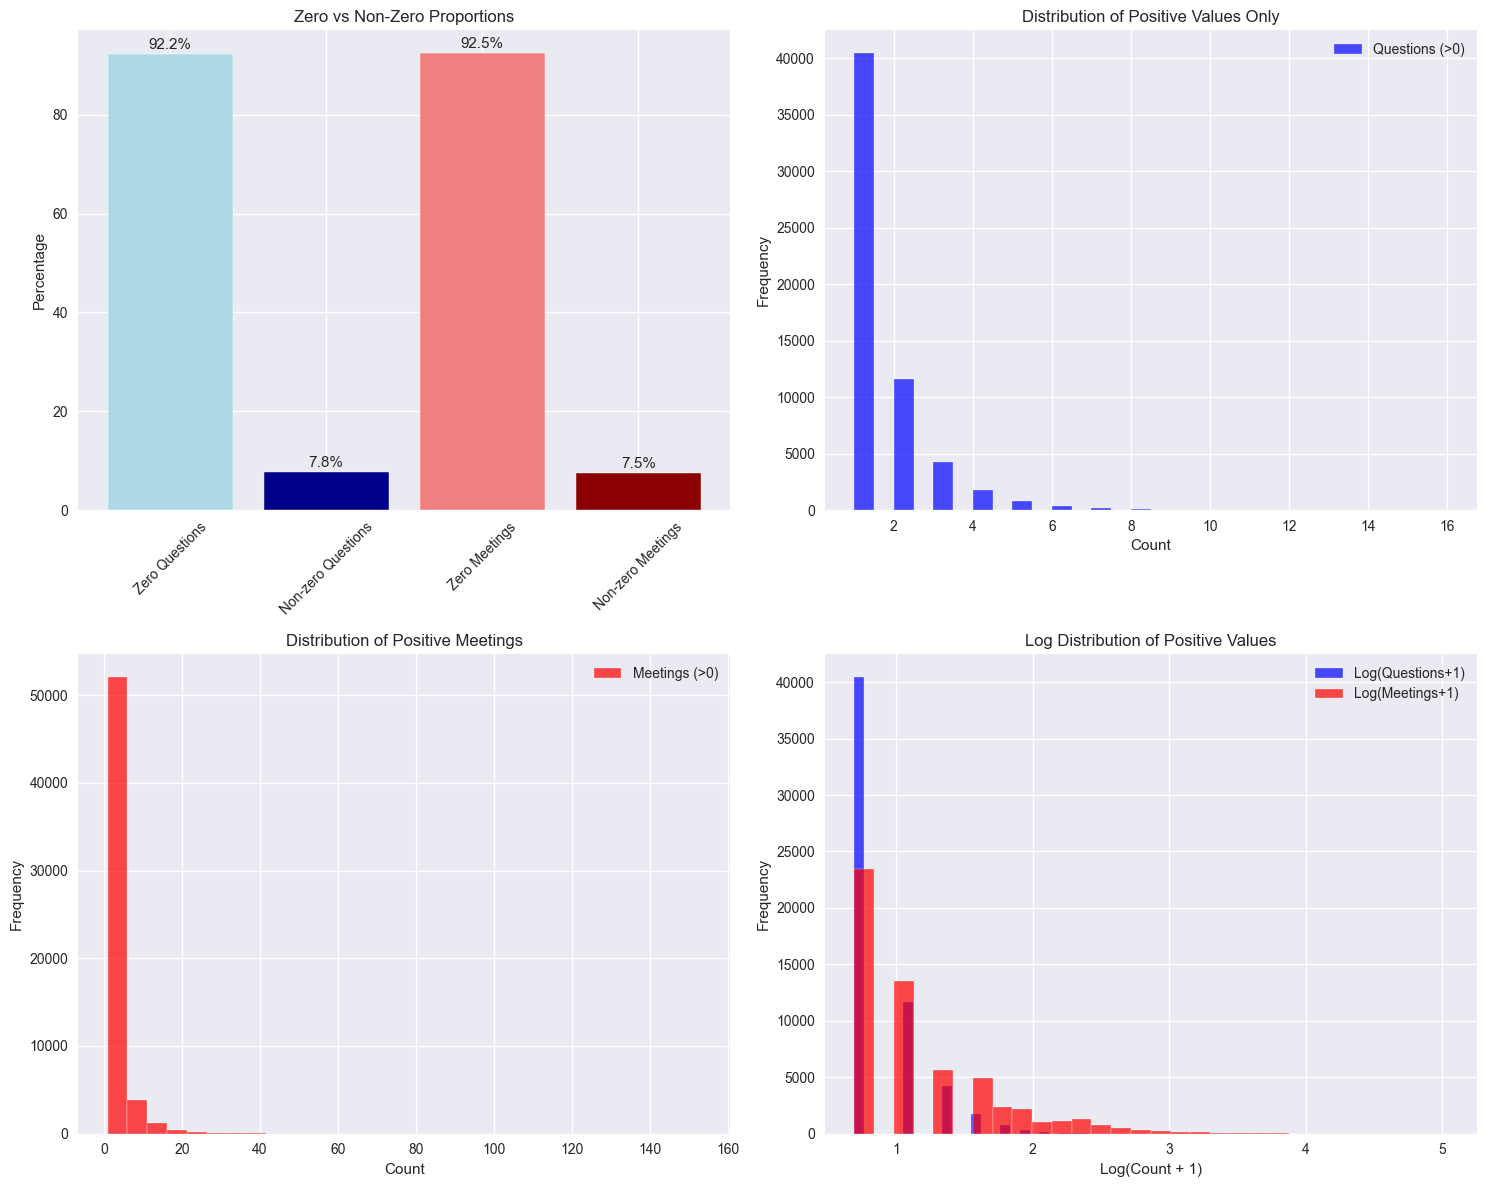

In [49]:
# =============================================================================
# ZERO-INFLATION SPECIFIC VISUALIZATIONS
# =============================================================================

# Create visualizations specifically for zero-inflated data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Zero vs Non-zero proportions
categories = ['Zero Questions', 'Non-zero Questions', 'Zero Meetings', 'Non-zero Meetings']
proportions = [
    (df['questions'] == 0).mean() * 100,
    (df['questions'] > 0).mean() * 100,
    (df['meetings'] == 0).mean() * 100,
    (df['meetings'] > 0).mean() * 100
]
colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred']

ax1.bar(categories, proportions, color=colors)
ax1.set_title('Zero vs Non-Zero Proportions')
ax1.set_ylabel('Percentage')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(proportions):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center')

# 2. Distribution of positive values only
positive_questions = df[df['questions'] > 0]['questions']
positive_meetings = df[df['meetings'] > 0]['meetings']

ax2.hist(positive_questions, bins=30, alpha=0.7, label='Questions (>0)', color='blue')
ax2.set_title('Distribution of Positive Values Only')
ax2.set_xlabel('Count')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Distribution of positive meetings
ax3.hist(positive_meetings, bins=30, alpha=0.7, label='Meetings (>0)', color='red')
ax3.set_title('Distribution of Positive Meetings')
ax3.set_xlabel('Count')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Log scale for positive values
ax4.hist(np.log1p(positive_questions), bins=30, alpha=0.7, label='Log(Questions+1)', color='blue')
ax4.hist(np.log1p(positive_meetings), bins=30, alpha=0.7, label='Log(Meetings+1)', color='red')
ax4.set_title('Log Distribution of Positive Values')
ax4.set_xlabel('Log(Count + 1)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()


# 🚨 KEY INSIGHTS FROM YOUR ZERO-INFLATION ANALYSIS

## Critical Findings:

### **Extreme Zero-Inflation (>92%)**
Your data shows **extremely high zero-inflation** in both variables:
- **Questions**: 92.24% zeros → Only ~7.8% of MEP-domain-month observations have any questions
- **Meetings**: 92.46% zeros → Only ~7.5% of MEP-domain-month observations have any meetings

### **Methodological Implications:**

#### **1. Count Data Models Are Essential**
- Standard OLS will be highly inefficient with this zero-inflation
- **Poisson/Negative Binomial** models are more appropriate
- **Zero-Inflated** models (ZIP, ZINB) should be considered
- **Hurdle models** might be optimal for this structure

#### **2. Two-Part Analysis Recommended**
Given the extreme zero-inflation, consider **separate analysis**:
1. **Extensive margin**: Binary model for ANY activity (0/1)
2. **Intensive margin**: Count model for LEVEL of activity (conditional on >0)

#### **3. Robustness Considerations**
- **Log transformations**: Use log(x+1) or IHS transformation
- **Winsorization**: Consider capping extreme values (max=153 meetings!)
- **Domain heterogeneity**: Zero rates likely vary dramatically by policy domain

## 📊 Additional Descriptive Tables Needed:

### **1. Zero-Inflation by Domain**
Show which policy domains have the highest/lowest activity rates

### **2. Extensive vs Intensive Margins**
Separate analysis of "participation" vs "intensity"

### **3. Outlier Analysis**
Investigate extreme values (16 questions, 153 meetings in a month!)

### **4. Temporal Patterns**
Show how zero-inflation varies over time

### **5. MEP-Level Persistence**
Analyze whether the same MEPs are consistently active


In [50]:
# =============================================================================
# EXTENSIVE VS INTENSIVE MARGIN ANALYSIS
# =============================================================================

print("\n=== EXTENSIVE VS INTENSIVE MARGIN ===")

# Extensive margin: Does MEP ask questions/have meetings? (0/1)
# Intensive margin: How many questions/meetings conditional on >0?

extensive_intensive = pd.DataFrame({
    'Margin': ['Extensive (Any Activity)', 'Intensive (Mean if >0)'],
    'Questions': [
        (df['questions'] > 0).mean() * 100,  # % with any questions
        df[df['questions'] > 0]['questions'].mean()  # Mean questions if >0
    ],
    'Meetings': [
        (df['meetings'] > 0).mean() * 100,  # % with any meetings
        df[df['meetings'] > 0]['meetings'].mean()  # Mean meetings if >0
    ]
}).round(3)

print(extensive_intensive.to_string(index=False))

# Cross-tabulation of extensive margins
print("\n=== CROSS-TABULATION: QUESTIONS vs MEETINGS ACTIVITY ===")
df['has_questions'] = (df['questions'] > 0).astype(int)
df['has_meetings'] = (df['meetings'] > 0).astype(int)

crosstab = pd.crosstab(df['has_questions'], df['has_meetings'], 
                      margins=True, margins_name='Total')
crosstab_pct = pd.crosstab(df['has_questions'], df['has_meetings'], 
                          normalize='all', margins=True, margins_name='Total') * 100

print("COUNTS:")
print(crosstab)
print("\nPERCENTAGES:")
print(crosstab_pct.round(2))



=== EXTENSIVE VS INTENSIVE MARGIN ===
                  Margin  Questions  Meetings
Extensive (Any Activity)      7.762     7.544
  Intensive (Mean if >0)      1.546     3.122

=== CROSS-TABULATION: QUESTIONS vs MEETINGS ACTIVITY ===
COUNTS:
has_meetings        0      1   Total
has_questions                       
0              660904  46700  707604
1               48375  11172   59547
Total          709279  57872  767151

PERCENTAGES:
has_meetings       0     1   Total
has_questions                     
0              86.15  6.09   92.24
1               6.31  1.46    7.76
Total          92.46  7.54  100.00
